In [78]:
%pylab
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
iris = load_iris()#导入iris数据集

data = iris.data
data = data[:100]
labels = iris.target
labels = labels[:100]
feature_name = iris.feature_names
print("feature_name", feature_name)

#我们选择了sepal length (cm)', 'sepal width (cm)'，并且更改了labels
data = data[:, 0:2]
labels[labels == 0] = -1
feature_name = feature_name[:2]

X_train, X_test, y_train, y_test = train_test_split(data, labels)#划分数据集

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
feature_name ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


C:\Users\hichens\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [79]:
np.dot(X_train.T, y_train)

array([ 27.6, -27.6])

In [87]:
class my_svm():
    def __init__(self, max_itr=90000, kernel_name='linear'):
        self.kernel_name = kernel_name
        self.max_itr = max_itr
        
    def input_param(self, features, labels):
        self.b = 0
        self.m, self.n = features.shape
        self.X = features
        self.y = labels
        
        self.alp = np.zeros(self.m)
        self.C = 1
        self.E = np.array([self.E_function(i) for i in range(self.m)])
        #sigma = np.std(self.X)
        
    #预测值
    def g_function(self, i):
        temp = 0
        xi = self.X[i]
        for j in range(self.m):
            xj = self.X[j]
            temp += self.alp[j]*self.y[j]*self.kernel(xi, xj)
        return temp + self.b
    
    #计算Ei值
    def E_function(self, i):
        return self.g_function(i) - self.y[i]
        
    #核函数
    def kernel(self, x, z):
        if self.kernel_name == 'linear':
            return np.dot(x, z)
        elif self.kernel_name == 'poly':
            return (np.dot(x, z) + 1)**2
        elif self.kernel_name == 'rbf':
            
            return np.exp(-(x-z)**2 / (2*self.sigma**2))
        return 0
    
    #mu函数
    def mu_function(self, x1, x2):
        return self.kernel(x1, x1) + self.kernel(x2, x2) - 2*self.kernel(x1, x2)
    
    #KKT条件
    def KKT(self, i):
        temp = self.y[i]*self.g_function(i)
        alp = self.alp[i]
        if alp == 0:
            return temp >= 1
        elif alp == self.C:
            return temp <= 1
        else:
            return temp == 1
    
    def fit(self, X, y):
        self.input_param(X, y)

        for itr in range(self.max_itr):
            for i in range(self.m):
                print(i)
                if not self.KKT(i):
                    b_old = self.b
                    alp1_old = self.alp[i]
                    y1 = self.y[i]
                    x1 = self.X[i]
                    E1 = self.E[i]

                    #alp2的选择
                    j = np.argmax(np.abs(self.E - E1))
                    alp2_old = self.alp[j]
                    y2 = self.y[j]
                    E2 = self.E[j]
                    x2 = self.X[j]
                    
                    mu = self.mu_function(x1, x2)
                    alp2_new_unc = alp2_old + y2*(E1 - E2)/mu
                    
                    #限制条件L， H
                    if y1 != y2:
                        L = max(0, alp2_old - alp1_old)
                        H = min(self.C, self.C + alp2_old + alp1_old)
                    else:
                        L = max(0, alp2_old + alp1_old - self.C)
                        H = min(self.C, alp2_old + alp1_old)
                    
                    #是否更新alp2
                    if alp2_new_unc > H:
                        alp2_new = H
                    elif alp2_new_unc < L:
                        alp2_new = L
                    else:
                        alp2_new = alp2_new_unc
                    
                    alp1_new = alp1_old +y1*y2*(alp2_old - alp2_new) # 更新alp1
                    
                    b1_new = -E1 - y1*self.kernel(x1, x1)*(alp1_new - alp1_old) - y2*self.kernel(x2, x1)*(alp2_new - alp2_old) + b_old
                    b2_new = -E2 - y1*self.kernel(x1, x2)*(alp1_new - alp1_old) - y2*self.kernel(x2, x2)*(alp2_new - alp2_old) + b_old
                    
                    if 0 < alp1_new < self.C:
                        b_new = b1_new
                    elif 0 < alp2_new < self.C:
                        b_new = b2_new
                    else:
                        b_new = (b1_new + b2_new)/2
                    
                    #更新参数
                    self.alp[i] = alp1_new
                    self.alp[j] = alp2_new
                    self.b = b_new

                    #重新计算E，更新
                    self.E[i] = self.E_function(i)
                    self.E[j] = self.E_function(j)
                    # print('i am here')

        return 'training done !'

    def predict(self, X):
        res = []
        for x in X:
            #temp从b开始累加
            temp = self.b
            for i in range(self.m):
                temp += self.alp[i]*self.y[i]*self.kernel(x, self.X[i])
            r = 1 if temp > 0 else -1
            res.append(r)
        return np.array(res)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

    def weight(self):
        return np.dot(self.alp, self.y.reshape(-1, 1)*self.X)

In [88]:
clf = my_svm(max_itr=1000)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

w = clf.weight()
b = clf.b
w, b

C:\Users\hichens\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars


(array([-4.62318046e+254,  2.49752631e+253]), 2.6222001731998305e+255)

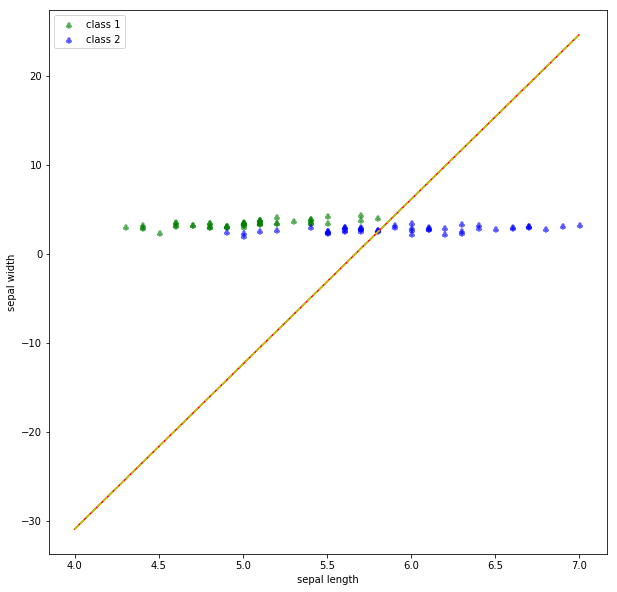

In [90]:
x_ponits = np.arange(4, 8)
y_ = -(w[0]*x_ponits + b)/w[1]
plt.figure(figsize=(10, 10))

plt.plot(x_ponits, y_, 'r')
plt.plot(x_ponits, y_+1/w[1], 'y--')
plt.plot(x_ponits, y_-1/w[1], 'y--')

plt.scatter(data[labels == -1][:, 0], data[labels == -1][:, 1],c="g", alpha=0.5, marker=r'$\clubsuit$',
            label="class 1")
plt.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], c="b", alpha=0.5, marker=r'$\clubsuit$',
            label="class 2")
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()



Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


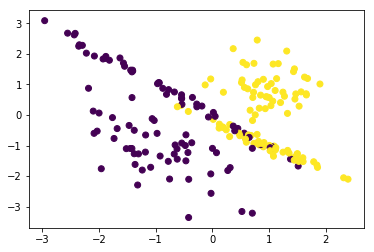

In [68]:
X, y = make_classification(n_samples=200, n_classes=2, n_features=2, n_redundant=0, n_clusters_per_class=2)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y)#划分数据集

clf = my_svm(max_itr=10)
clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
0
1
2
3
4
5
6
7
8
9


0.5

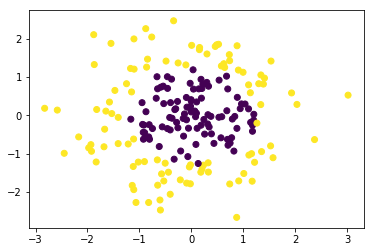

In [70]:
X, y = make_gaussian_quantiles(n_samples=200, n_features=2, n_classes=2)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)

0.82

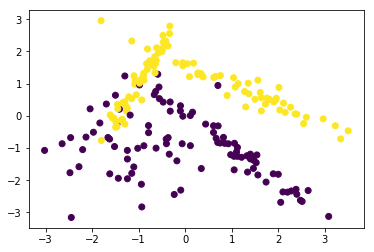

In [73]:

X, y = make_classification(n_samples=200, n_classes=2, n_features=2, n_redundant=0, n_clusters_per_class=2)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
X_train, X_test, y_train, y_test = train_test_split(X, y)#划分数据集

from sklearn.svm import SVC
clf = SVC(kernel='linear')
clf.fit(X_train ,y_train)
clf.score(X_test, y_test)